In [2]:
!pip install -q torch transformers peft bitsandbytes sacrebleu rouge_score evaluate nltk pandas tqdm
import nltk
# Tải dữ liệu cần thiết cho metrics
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
print("Libraries installed successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


Libraries installed successfully.


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import os
from datasets import Dataset

DATA_DIR = '/kaggle/input/vlspdata' 
ADAPTER_PATH = '/kaggle/input/vlsp/pytorch/default/1'

def load_local_text(file_path):
    if not os.path.exists(file_path):
        print(f"ERROR: File {file_path} not found.")
        return []
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip()]
    return lines

test_vi_lines = load_local_text(os.path.join(DATA_DIR, 'public_test.vi (1).txt'))
test_en_lines = load_local_text(os.path.join(DATA_DIR, 'public_test.en.txt'))

min_len = min(len(test_vi_lines), len(test_en_lines))
test_vi = test_vi_lines[:min_len]
test_en = test_en_lines[:min_len]

print(f"Loaded {len(test_en)} test samples.")
print(f"Sample En: {test_en[0]}")
print(f"Sample Vi: {test_vi[0]}")

Loaded 3000 test samples.
Sample En: Knowledge, practices in public health service utilization among health insurance card’s holders and influencing factors in Vientiane, Lao
Sample Vi: Thực trạng kiến thức và thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố ảnh hưởng tại tỉnh Viêng Chăn, CHDCND Lào, năm 2017


In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel

# Base Model ID
base_model_id = "Qwen/Qwen2.5-1.5B"

# Config 4-bit để tránh OOM trên T4 GPU
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

print("Loading Base Model...")
tokenizer = AutoTokenizer.from_pretrained(ADAPTER_PATH, trust_remote_code=True)
# Fix padding token cho Qwen
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left" # Quan trọng cho generation only

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

print(f"Loading Adapter from {ADAPTER_PATH}...")
model = PeftModel.from_pretrained(base_model, ADAPTER_PATH)
model.eval()

print("Model loaded successfully!")

2025-12-22 17:14:48.816048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766423689.078037      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766423689.151500      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Loading Base Model...


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Loading Adapter from /kaggle/input/vlsp/pytorch/default/1...


/usr/local/lib/python3.11/dist-packages/peft/config.py:165: UserWarning: Unexpected keyword arguments ['alora_invocation_tokens', 'arrow_config', 'ensure_weight_tying', 'peft_version', 'target_parameters'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(


Model loaded successfully!


STARTING EVALUATION (1000 SAMPLES)...

============================== PROCESSING EN2VI (1000 samples) ==============================


en2vi: 100%|██████████| 125/125 [15:28<00:00,  7.42s/it, BLEU=32.53]



============================== PROCESSING VI2EN (1000 samples) ==============================


vi2en: 100%|██████████| 125/125 [12:11<00:00,  5.85s/it, BLEU=23.52]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



METRIC                              | EN-VI        | VI-EN        | OVERALL     
-------------------------------------------------------------------------------------
Corpus BLEU (↑)                     | 32.53        | 23.52        | 28.02       
TER (↓)                             | 57.75        | 65.38        | 61.56       
Semantic Score (↑)                  | 0.8611       | 0.9242       | 0.8927      


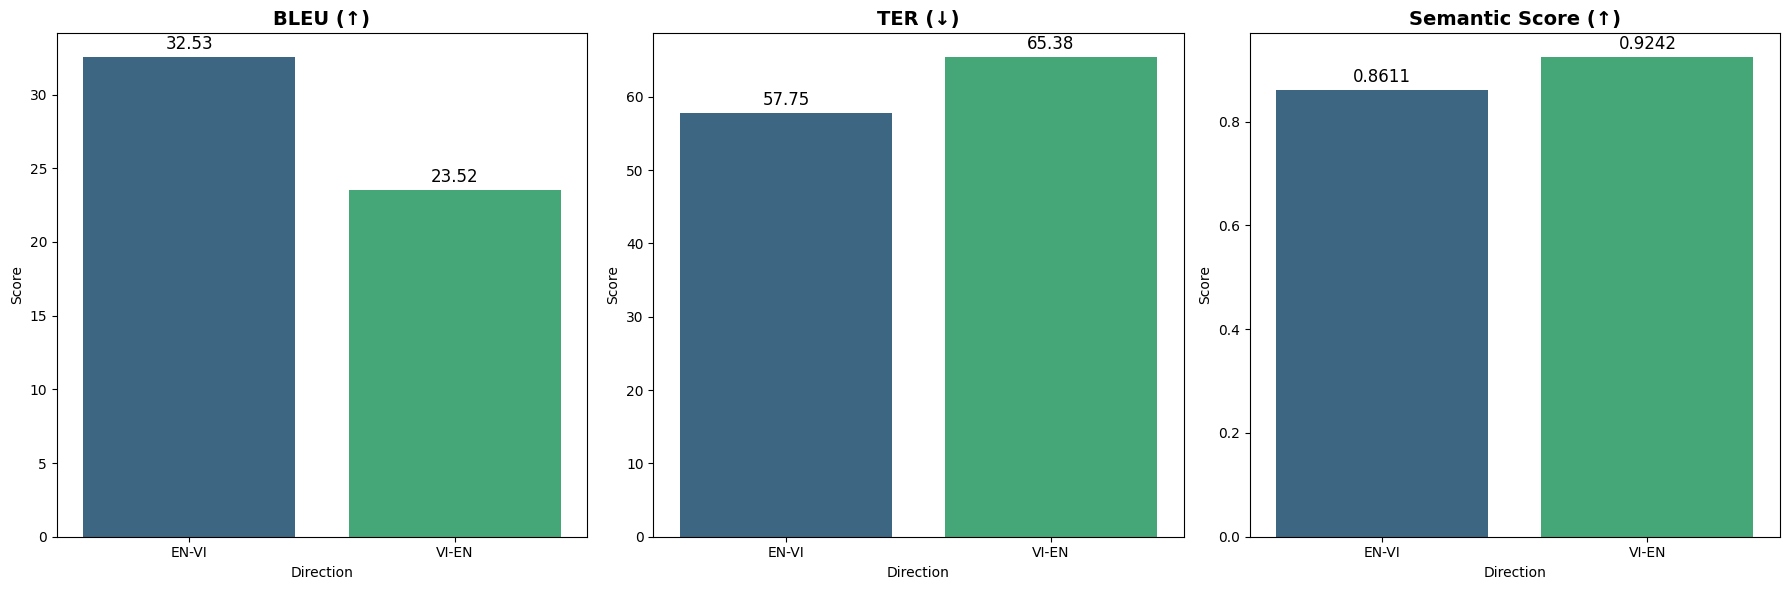


[Done]: Kết quả đã được lưu vào massive_eval_results.csv và biểu đồ report.


In [29]:
import torch
import re
import numpy as np
from tqdm import tqdm
import sacrebleu
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import StoppingCriteria, StoppingCriteriaList
from bert_score import score as bert_score_func

NUM_SAMPLES = 1000
BATCH_SIZE = 8

class StopOnWordCriteria(StoppingCriteria):
    def __init__(self, target_word, tokenizer):
        self.target_word = target_word
        self.tokenizer = tokenizer

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        last_tokens = input_ids[0, -10:]
        decoded_last = self.tokenizer.decode(last_tokens)
        return self.target_word in decoded_last

def clean_prediction(raw_text):
    stop_marker = "(end)"
    if stop_marker in raw_text:
        clean_text = raw_text[:raw_text.find(stop_marker)]
    else:
        clean_text = raw_text
    return clean_text.strip()

def calculate_metrics(preds, refs):
    # Tính BLEU (Càng cao càng tốt)
    bleu = sacrebleu.corpus_bleu(preds, [refs]).score
    # Tính TER (Càng thấp càng tốt)
    ter = sacrebleu.corpus_ter(preds, [refs]).score
    return bleu, ter

def generate_with_live_monitoring(model, tokenizer, inputs_text, refs_text, direction="en2vi"):
    inputs_subset = inputs_text[:NUM_SAMPLES]
    refs_subset = refs_text[:NUM_SAMPLES]

    print(f"\n{'='*30} PROCESSING {direction.upper()} ({len(inputs_subset)} samples) {'='*30}")

    stop_criteria = StoppingCriteriaList([StopOnWordCriteria("(end)", tokenizer)])
    all_preds, all_refs = [], [] 

    pbar = tqdm(range(0, len(inputs_subset), BATCH_SIZE), desc=f"{direction}")
    
    for i in pbar:
        batch_src = inputs_subset[i : i + BATCH_SIZE]
        batch_refs_text = refs_subset[i : i + BATCH_SIZE]
        
        prompts = []
        for text in batch_src:
            if direction == "en2vi":
                p = (f"Translate English to Vietnamese (Medical), Only provide the Vietnamese result, end with (end):\n"
                     f"English: Patient with acute myocardial infarction.\nVietnamese: Bệnh nhân bị nhồi máu cơ tim cấp. (end)\n"
                     f"English: {text.strip()}\nVietnamese:")
            else:
                p = (f"Translate Vietnamese to English (Medical domain), Only provide the English result, end with (end):\n"
                     f"Vietnamese: Bệnh nhân bị nhồi máu cơ tim cấp.\nEnglish: Patient with acute myocardial infarction. (end)\n"
                     f"Vietnamese: {text.strip()}\nEnglish:")
            prompts.append(p)

        inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=1024).to(model.device)
        
        with torch.no_grad():
            output_ids = model.generate(
                **inputs,
                max_new_tokens=256,
                do_sample=False,         
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                repetition_penalty=1.05,
                stopping_criteria=stop_criteria
            )
        
        decoded_batch = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        
        batch_preds_clean = []
        for text in decoded_batch:
            split_keyword = "Vietnamese:" if direction == "en2vi" else "English:"
            raw_output = text.split(split_keyword)[-1]
            batch_preds_clean.append(clean_prediction(raw_output))

        all_preds.extend(batch_preds_clean)
        all_refs.extend(batch_refs_text)
        
        temp_bleu = sacrebleu.corpus_bleu(all_preds, [all_refs]).score
        pbar.set_postfix({"BLEU": f"{temp_bleu:.2f}"})
        torch.cuda.empty_cache()

    bleu, ter = calculate_metrics(all_preds, all_refs)
    _, _, F1_total = bert_score_func(all_preds, all_refs, lang=("vi" if direction=="en2vi" else "en"), device=str(model.device))
    semantic = F1_total.mean().item()

    return all_preds, {"bleu": bleu, "ter": ter, "semantic": semantic}

def plot_results(m_en2vi, m_vi2en):
    metrics = ['bleu', 'ter', 'semantic']
    titles = ['BLEU (↑)', 'TER (↓)', 'Semantic Score (↑)']
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, m in enumerate(metrics):
        df_plot = pd.DataFrame({'Direction': ['EN-VI', 'VI-EN'], 'Score': [m_en2vi[m], m_vi2en[m]]})
        sns.barplot(x='Direction', y='Score', data=df_plot, ax=axes[i], palette='viridis')
        axes[i].set_title(titles[i], fontweight='bold', fontsize=14)
        for container in axes[i].containers:
            axes[i].bar_label(container, fmt='%.2f' if m != 'semantic' else '%.4f', padding=3, fontsize=12)
            
    plt.tight_layout()
    plt.savefig('translation_comparison_report.png')
    plt.show()

print(f"STARTING EVALUATION ({NUM_SAMPLES} SAMPLES)...")

preds_en2vi, m_en2vi = generate_with_live_monitoring(model, tokenizer, test_en, test_vi, "en2vi")
preds_vi2en, m_vi2en = generate_with_live_monitoring(model, tokenizer, test_vi, test_en, "vi2en")

# Tính trung bình cộng Overall
overall = {k: (m_en2vi[k] + m_vi2en[k]) / 2 for k in m_en2vi.keys()}

print("\n" + "="*85)
print(f"{'METRIC':<35} | {'EN-VI':<12} | {'VI-EN':<12} | {'OVERALL':<12}")
print("-" * 85)
for k, name in zip(['bleu', 'ter', 'semantic'], ['Corpus BLEU (↑)', 'TER (↓)', 'Semantic Score (↑)']):
    fmt = ".2f" if k != 'semantic' else ".4f"
    print(f"{name:<35} | {m_en2vi[k]:<12{fmt}} | {m_vi2en[k]:<12{fmt}} | {overall[k]:<12{fmt}}")
print("="*85)

# Vẽ biểu đồ so sánh
plot_results(m_en2vi, m_vi2en)

# Lưu file kết quả tổng hợp
df_final = pd.DataFrame({
    "Source": test_en[:NUM_SAMPLES] + test_vi[:NUM_SAMPLES],
    "Reference": test_vi[:NUM_SAMPLES] + test_en[:NUM_SAMPLES],
    "Prediction": preds_en2vi + preds_vi2en,
    "Direction": ["En-Vi"]*NUM_SAMPLES + ["Vi-En"]*NUM_SAMPLES
})
df_final.to_csv("massive_eval_results.csv", index=False, encoding='utf-8-sig')
print("\n[Done]: Kết quả đã được lưu vào massive_eval_results.csv và biểu đồ report.")